In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import snowFun
import dask.array
import sklearn
from sklearn.linear_model import LinearRegression
# %matplotlib widget

In [2]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, drop='geometry')

In [4]:
### choose if you want to do only the 45 validation glaciers
validation_only = 0

# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))

### get list of all the glaciers for which we have calculated the snow covered fractions
# select which rgis to analyze
if validation_only:
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation')
else:
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')

folder_sca = os.path.join(folder_save, 'Band SCFs')
annual_aa_folder = os.path.join(folder_save, 'Annual AAs')
annual_ela_folder = os.path.join(folder_save, 'Annual AAs', 'csv')

# load rgi names that have been saved to the classified folder
rgis_to_analyze = list(set( [ i[3:17] for i in os.listdir(folder_sca) if i!='merged.vrt' ] ))

# get list of glacier area for each rgi
areas = [rgi_gdf[rgi_gdf['RGIId']==i]['Area'].values for i in rgis_to_analyze]

# make df
rgis_to_analyze_df = pd.DataFrame({"RGIId":rgis_to_analyze, 'Area':areas})

# sort however you want
rgis_to_analyze_df = rgis_to_analyze_df.sort_values('Area')

# grab rgi names
rgis_to_analyze = rgis_to_analyze_df['RGIId'].values

print(len(rgis_to_analyze_df))

3023


In [18]:
all_df = []
all_years = [2018,2019,2020,2021,2022]

for i in range(len(rgis_to_analyze)):
#     if i>0: continue
    # subset rgi to single outline, by choosing rgiid or rgi name
    rgiid = rgis_to_analyze[i]

    # quickly grab glacier area
    ga = rgi_gdf[rgi_gdf['RGIId']==rgiid]['Area'].values[0]
    gn = rgi_gdf[rgi_gdf['RGIId']==rgiid]['Name'].values[0]
#     if gn != 'Wolverine Glacier': continue
#     if ga<500: continue
        
    # print progress
    print(f"Starting {i+1} of {len(rgis_to_analyze)}: {rgiid}  {ga} km2")
    
    # open the glacier-specific complexity csv
    path = os.path.join(folder_save, 'Snowline Complexity', f"{rgiid}.csv")
    df_fracs = pd.read_csv(path)
    df_fracs['min'] = [int(i.split("_")[0]) for i in df_fracs['percent_range']]
    df_fracs['max'] = [int(i.split("_")[1]) for i in df_fracs['percent_range']]
    
    # get list of columns
    all_cols = df_fracs.columns.values
    
    # for each year for each glacier, calculate the fraction of elevation bands that are 25-75% snow
    idx_c = ((df_fracs['min']>40) & (df_fracs['max']<60))
    idx_s = (df_fracs['max']<15)
    
    dic = {"RGIId":rgiid, 'Area':ga}
    for y in all_years:
        cn = f"{y}_band_fraction"
        if cn in all_cols:
            dic[f'{y}_complexity'] = round(np.nansum(df_fracs[idx_c][f"{y}_band_fraction"]),4)
            dic[f'{y}_simplicity'] = round(np.nansum(df_fracs[idx_s][f"{y}_band_fraction"]),4)
        else:
            dic[f'{y}_complexity'] = np.nan
            dic[f'{y}_simplicity'] = np.nan
            
        
    
    all_df.append(dic)
    
all_df = pd.DataFrame(all_df)

Starting 1 of 3023: RGI60-01.20889  2.0 km2
Starting 2 of 3023: RGI60-01.11632  2.0 km2
Starting 3 of 3023: RGI60-01.25183  2.002 km2
Starting 4 of 3023: RGI60-01.08203  2.002 km2
Starting 5 of 3023: RGI60-01.11595  2.003 km2
Starting 6 of 3023: RGI60-01.09047  2.004 km2
Starting 7 of 3023: RGI60-01.03614  2.004 km2
Starting 8 of 3023: RGI60-01.05487  2.004 km2
Starting 9 of 3023: RGI60-01.10867  2.005 km2
Starting 10 of 3023: RGI60-01.17509  2.005 km2
Starting 11 of 3023: RGI60-01.03088  2.005 km2
Starting 12 of 3023: RGI60-01.08199  2.006 km2
Starting 13 of 3023: RGI60-01.12977  2.006 km2
Starting 14 of 3023: RGI60-01.02453  2.006 km2
Starting 15 of 3023: RGI60-01.19457  2.007 km2
Starting 16 of 3023: RGI60-01.05254  2.009 km2
Starting 17 of 3023: RGI60-01.02906  2.01 km2
Starting 18 of 3023: RGI60-01.19826  2.012 km2
Starting 19 of 3023: RGI60-01.03773  2.012 km2
Starting 20 of 3023: RGI60-01.00315  2.014 km2
Starting 21 of 3023: RGI60-01.00564  2.015 km2
Starting 22 of 3023: RGI60-

Starting 197 of 3023: RGI60-01.18960  2.143 km2
Starting 198 of 3023: RGI60-01.13590  2.144 km2
Starting 199 of 3023: RGI60-01.21185  2.145 km2
Starting 200 of 3023: RGI60-01.04295  2.147 km2
Starting 201 of 3023: RGI60-01.20914  2.148 km2
Starting 202 of 3023: RGI60-01.13028  2.149 km2
Starting 203 of 3023: RGI60-01.03404  2.15 km2
Starting 204 of 3023: RGI60-01.00314  2.156 km2
Starting 205 of 3023: RGI60-01.08346  2.156 km2
Starting 206 of 3023: RGI60-01.10969  2.156 km2
Starting 207 of 3023: RGI60-01.03414  2.157 km2
Starting 208 of 3023: RGI60-01.24911  2.158 km2
Starting 209 of 3023: RGI60-01.17892  2.158 km2
Starting 210 of 3023: RGI60-01.11557  2.159 km2
Starting 211 of 3023: RGI60-01.00390  2.16 km2
Starting 212 of 3023: RGI60-01.00159  2.161 km2
Starting 213 of 3023: RGI60-01.21768  2.162 km2
Starting 214 of 3023: RGI60-01.25410  2.162 km2
Starting 215 of 3023: RGI60-01.11611  2.164 km2
Starting 216 of 3023: RGI60-01.04534  2.167 km2
Starting 217 of 3023: RGI60-01.24574  2.16

Starting 398 of 3023: RGI60-01.06446  2.31 km2
Starting 399 of 3023: RGI60-01.02879  2.311 km2
Starting 400 of 3023: RGI60-01.23337  2.312 km2
Starting 401 of 3023: RGI60-01.16482  2.312 km2
Starting 402 of 3023: RGI60-01.03976  2.312 km2
Starting 403 of 3023: RGI60-01.05224  2.312 km2
Starting 404 of 3023: RGI60-01.02620  2.314 km2
Starting 405 of 3023: RGI60-01.02875  2.315 km2
Starting 406 of 3023: RGI60-01.04014  2.318 km2
Starting 407 of 3023: RGI60-01.16515  2.318 km2
Starting 408 of 3023: RGI60-01.05307  2.319 km2
Starting 409 of 3023: RGI60-01.09822  2.319 km2
Starting 410 of 3023: RGI60-01.25705  2.319 km2
Starting 411 of 3023: RGI60-01.19858  2.32 km2
Starting 412 of 3023: RGI60-01.09517  2.322 km2
Starting 413 of 3023: RGI60-01.23569  2.322 km2
Starting 414 of 3023: RGI60-01.22803  2.324 km2
Starting 415 of 3023: RGI60-01.13969  2.325 km2
Starting 416 of 3023: RGI60-01.13315  2.325 km2
Starting 417 of 3023: RGI60-01.15962  2.326 km2
Starting 418 of 3023: RGI60-01.02615  2.32

Starting 576 of 3023: RGI60-01.23675  2.499 km2
Starting 577 of 3023: RGI60-01.12014  2.499 km2
Starting 578 of 3023: RGI60-01.09713  2.499 km2
Starting 579 of 3023: RGI60-01.01783  2.499 km2
Starting 580 of 3023: RGI60-01.07522  2.5 km2
Starting 581 of 3023: RGI60-01.00814  2.5 km2
Starting 582 of 3023: RGI60-01.20807  2.502 km2
Starting 583 of 3023: RGI60-01.04982  2.502 km2
Starting 584 of 3023: RGI60-01.17659  2.503 km2
Starting 585 of 3023: RGI60-01.00368  2.504 km2
Starting 586 of 3023: RGI60-01.11306  2.505 km2
Starting 587 of 3023: RGI60-01.16066  2.505 km2
Starting 588 of 3023: RGI60-01.05291  2.505 km2
Starting 589 of 3023: RGI60-01.11690  2.506 km2
Starting 590 of 3023: RGI60-01.26986  2.507 km2
Starting 591 of 3023: RGI60-01.23971  2.507 km2
Starting 592 of 3023: RGI60-01.20639  2.509 km2
Starting 593 of 3023: RGI60-01.08141  2.51 km2
Starting 594 of 3023: RGI60-01.13383  2.512 km2
Starting 595 of 3023: RGI60-01.03176  2.514 km2
Starting 596 of 3023: RGI60-01.16969  2.517 k

Starting 763 of 3023: RGI60-01.13001  2.723 km2
Starting 764 of 3023: RGI60-01.05936  2.728 km2
Starting 765 of 3023: RGI60-01.03386  2.73 km2
Starting 766 of 3023: RGI60-01.03418  2.735 km2
Starting 767 of 3023: RGI60-01.18164  2.737 km2
Starting 768 of 3023: RGI60-01.11857  2.738 km2
Starting 769 of 3023: RGI60-01.09031  2.739 km2
Starting 770 of 3023: RGI60-01.15185  2.739 km2
Starting 771 of 3023: RGI60-01.14525  2.741 km2
Starting 772 of 3023: RGI60-01.14333  2.744 km2
Starting 773 of 3023: RGI60-01.07743  2.745 km2
Starting 774 of 3023: RGI60-01.24661  2.748 km2
Starting 775 of 3023: RGI60-01.10551  2.75 km2
Starting 776 of 3023: RGI60-01.04764  2.75 km2
Starting 777 of 3023: RGI60-01.13563  2.751 km2
Starting 778 of 3023: RGI60-01.19082  2.751 km2
Starting 779 of 3023: RGI60-01.02946  2.752 km2
Starting 780 of 3023: RGI60-01.04973  2.752 km2
Starting 781 of 3023: RGI60-01.09178  2.754 km2
Starting 782 of 3023: RGI60-01.00171  2.754 km2
Starting 783 of 3023: RGI60-01.15259  2.755

Starting 947 of 3023: RGI60-01.01506  2.957 km2
Starting 948 of 3023: RGI60-01.02399  2.962 km2
Starting 949 of 3023: RGI60-01.00907  2.963 km2
Starting 950 of 3023: RGI60-01.21009  2.965 km2
Starting 951 of 3023: RGI60-01.05968  2.965 km2
Starting 952 of 3023: RGI60-01.12169  2.968 km2
Starting 953 of 3023: RGI60-01.03481  2.974 km2
Starting 954 of 3023: RGI60-01.03759  2.977 km2
Starting 955 of 3023: RGI60-01.09677  2.981 km2
Starting 956 of 3023: RGI60-01.01419  2.983 km2
Starting 957 of 3023: RGI60-01.10981  2.984 km2
Starting 958 of 3023: RGI60-01.09226  2.984 km2
Starting 959 of 3023: RGI60-01.14385  2.986 km2
Starting 960 of 3023: RGI60-01.05576  2.986 km2
Starting 961 of 3023: RGI60-01.03796  2.988 km2
Starting 962 of 3023: RGI60-01.13402  2.988 km2
Starting 963 of 3023: RGI60-01.20844  2.989 km2
Starting 964 of 3023: RGI60-01.04614  2.993 km2
Starting 965 of 3023: RGI60-01.05086  2.994 km2
Starting 966 of 3023: RGI60-01.12103  2.994 km2
Starting 967 of 3023: RGI60-01.22220  2.

Starting 1144 of 3023: RGI60-01.11074  3.335 km2
Starting 1145 of 3023: RGI60-01.18100  3.337 km2
Starting 1146 of 3023: RGI60-01.09525  3.338 km2
Starting 1147 of 3023: RGI60-01.22812  3.338 km2
Starting 1148 of 3023: RGI60-01.04487  3.34 km2
Starting 1149 of 3023: RGI60-01.02697  3.34 km2
Starting 1150 of 3023: RGI60-01.10440  3.341 km2
Starting 1151 of 3023: RGI60-01.15735  3.341 km2
Starting 1152 of 3023: RGI60-01.19540  3.342 km2
Starting 1153 of 3023: RGI60-01.02831  3.342 km2
Starting 1154 of 3023: RGI60-01.09319  3.343 km2
Starting 1155 of 3023: RGI60-01.01822  3.351 km2
Starting 1156 of 3023: RGI60-01.17190  3.352 km2
Starting 1157 of 3023: RGI60-01.19695  3.354 km2
Starting 1158 of 3023: RGI60-01.19390  3.355 km2
Starting 1159 of 3023: RGI60-01.04544  3.355 km2
Starting 1160 of 3023: RGI60-01.08841  3.356 km2
Starting 1161 of 3023: RGI60-01.19942  3.356 km2
Starting 1162 of 3023: RGI60-01.02628  3.356 km2
Starting 1163 of 3023: RGI60-01.04758  3.359 km2
Starting 1164 of 3023:

Starting 1329 of 3023: RGI60-01.17798  3.719 km2
Starting 1330 of 3023: RGI60-01.13468  3.721 km2
Starting 1331 of 3023: RGI60-01.20814  3.728 km2
Starting 1332 of 3023: RGI60-01.22232  3.729 km2
Starting 1333 of 3023: RGI60-01.01708  3.731 km2
Starting 1334 of 3023: RGI60-01.05973  3.736 km2
Starting 1335 of 3023: RGI60-01.08198  3.737 km2
Starting 1336 of 3023: RGI60-01.22276  3.738 km2
Starting 1337 of 3023: RGI60-01.25626  3.739 km2
Starting 1338 of 3023: RGI60-01.17521  3.739 km2
Starting 1339 of 3023: RGI60-01.16424  3.743 km2
Starting 1340 of 3023: RGI60-01.03809  3.751 km2
Starting 1341 of 3023: RGI60-01.12232  3.754 km2
Starting 1342 of 3023: RGI60-01.18140  3.755 km2
Starting 1343 of 3023: RGI60-01.01670  3.755 km2
Starting 1344 of 3023: RGI60-01.05836  3.756 km2
Starting 1345 of 3023: RGI60-01.15334  3.757 km2
Starting 1346 of 3023: RGI60-01.15707  3.757 km2
Starting 1347 of 3023: RGI60-01.03742  3.757 km2
Starting 1348 of 3023: RGI60-01.12179  3.761 km2
Starting 1349 of 302

Starting 1511 of 3023: RGI60-01.00593  4.192 km2
Starting 1512 of 3023: RGI60-01.18053  4.194 km2
Starting 1513 of 3023: RGI60-01.05958  4.195 km2
Starting 1514 of 3023: RGI60-01.16613  4.2 km2
Starting 1515 of 3023: RGI60-01.04823  4.202 km2
Starting 1516 of 3023: RGI60-01.20638  4.202 km2
Starting 1517 of 3023: RGI60-01.21732  4.205 km2
Starting 1518 of 3023: RGI60-01.09927  4.207 km2
Starting 1519 of 3023: RGI60-01.17396  4.209 km2
Starting 1520 of 3023: RGI60-01.19503  4.216 km2
Starting 1521 of 3023: RGI60-01.08764  4.224 km2
Starting 1522 of 3023: RGI60-01.13469  4.227 km2
Starting 1523 of 3023: RGI60-01.20721  4.238 km2
Starting 1524 of 3023: RGI60-01.01602  4.242 km2
Starting 1525 of 3023: RGI60-01.14828  4.242 km2
Starting 1526 of 3023: RGI60-01.26384  4.243 km2
Starting 1527 of 3023: RGI60-01.01666  4.243 km2
Starting 1528 of 3023: RGI60-01.18085  4.244 km2
Starting 1529 of 3023: RGI60-01.14512  4.244 km2
Starting 1530 of 3023: RGI60-01.09316  4.244 km2
Starting 1531 of 3023:

Starting 1685 of 3023: RGI60-01.20535  4.752 km2
Starting 1686 of 3023: RGI60-01.03761  4.753 km2
Starting 1687 of 3023: RGI60-01.20801  4.762 km2
Starting 1688 of 3023: RGI60-01.15516  4.764 km2
Starting 1689 of 3023: RGI60-01.01150  4.765 km2
Starting 1690 of 3023: RGI60-01.00558  4.772 km2
Starting 1691 of 3023: RGI60-01.20234  4.776 km2
Starting 1692 of 3023: RGI60-01.14180  4.778 km2
Starting 1693 of 3023: RGI60-01.03740  4.781 km2
Starting 1694 of 3023: RGI60-01.13511  4.782 km2
Starting 1695 of 3023: RGI60-01.17895  4.785 km2
Starting 1696 of 3023: RGI60-01.04436  4.79 km2
Starting 1697 of 3023: RGI60-01.08398  4.793 km2
Starting 1698 of 3023: RGI60-01.19548  4.796 km2
Starting 1699 of 3023: RGI60-01.03747  4.809 km2
Starting 1700 of 3023: RGI60-01.09847  4.81 km2
Starting 1701 of 3023: RGI60-01.23220  4.819 km2
Starting 1702 of 3023: RGI60-01.16606  4.822 km2
Starting 1703 of 3023: RGI60-01.14295  4.824 km2
Starting 1704 of 3023: RGI60-01.17472  4.828 km2
Starting 1705 of 3023:

Starting 1865 of 3023: RGI60-01.19586  5.61 km2
Starting 1866 of 3023: RGI60-01.19037  5.611 km2
Starting 1867 of 3023: RGI60-01.13222  5.617 km2
Starting 1868 of 3023: RGI60-01.09177  5.618 km2
Starting 1869 of 3023: RGI60-01.14413  5.62 km2
Starting 1870 of 3023: RGI60-01.09606  5.624 km2
Starting 1871 of 3023: RGI60-01.11474  5.63 km2
Starting 1872 of 3023: RGI60-01.12551  5.641 km2
Starting 1873 of 3023: RGI60-01.00298  5.645 km2
Starting 1874 of 3023: RGI60-01.16195  5.655 km2
Starting 1875 of 3023: RGI60-01.03734  5.655 km2
Starting 1876 of 3023: RGI60-01.07390  5.656 km2
Starting 1877 of 3023: RGI60-01.03716  5.674 km2
Starting 1878 of 3023: RGI60-01.20303  5.687 km2
Starting 1879 of 3023: RGI60-01.08299  5.7 km2
Starting 1880 of 3023: RGI60-01.10756  5.702 km2
Starting 1881 of 3023: RGI60-01.21788  5.707 km2
Starting 1882 of 3023: RGI60-01.05255  5.712 km2
Starting 1883 of 3023: RGI60-01.19937  5.714 km2
Starting 1884 of 3023: RGI60-01.14783  5.714 km2
Starting 1885 of 3023: RG

Starting 2043 of 3023: RGI60-01.17621  7.058 km2
Starting 2044 of 3023: RGI60-01.20455  7.058 km2
Starting 2045 of 3023: RGI60-01.20998  7.064 km2
Starting 2046 of 3023: RGI60-01.19394  7.085 km2
Starting 2047 of 3023: RGI60-01.22668  7.089 km2
Starting 2048 of 3023: RGI60-01.16509  7.096 km2
Starting 2049 of 3023: RGI60-01.03735  7.111 km2
Starting 2050 of 3023: RGI60-01.19155  7.114 km2
Starting 2051 of 3023: RGI60-01.20774  7.114 km2
Starting 2052 of 3023: RGI60-01.04294  7.12 km2
Starting 2053 of 3023: RGI60-01.03129  7.121 km2
Starting 2054 of 3023: RGI60-01.05126  7.126 km2
Starting 2055 of 3023: RGI60-01.15171  7.142 km2
Starting 2056 of 3023: RGI60-01.14422  7.151 km2
Starting 2057 of 3023: RGI60-01.12747  7.156 km2
Starting 2058 of 3023: RGI60-01.04937  7.157 km2
Starting 2059 of 3023: RGI60-01.20831  7.167 km2
Starting 2060 of 3023: RGI60-01.20337  7.168 km2
Starting 2061 of 3023: RGI60-01.05816  7.178 km2
Starting 2062 of 3023: RGI60-01.17748  7.195 km2
Starting 2063 of 3023

Starting 2213 of 3023: RGI60-01.15549  9.081 km2
Starting 2214 of 3023: RGI60-01.03017  9.09 km2
Starting 2215 of 3023: RGI60-01.15184  9.093 km2
Starting 2216 of 3023: RGI60-01.19483  9.133 km2
Starting 2217 of 3023: RGI60-01.22240  9.145 km2
Starting 2218 of 3023: RGI60-01.13988  9.145 km2
Starting 2219 of 3023: RGI60-01.18004  9.172 km2
Starting 2220 of 3023: RGI60-01.10394  9.188 km2
Starting 2221 of 3023: RGI60-01.11775  9.201 km2
Starting 2222 of 3023: RGI60-01.14104  9.211 km2
Starting 2223 of 3023: RGI60-01.05007  9.216 km2
Starting 2224 of 3023: RGI60-01.18237  9.244 km2
Starting 2225 of 3023: RGI60-01.12311  9.244 km2
Starting 2226 of 3023: RGI60-01.11590  9.249 km2
Starting 2227 of 3023: RGI60-01.04675  9.249 km2
Starting 2228 of 3023: RGI60-01.01433  9.26 km2
Starting 2229 of 3023: RGI60-01.16902  9.326 km2
Starting 2230 of 3023: RGI60-01.26940  9.33 km2
Starting 2231 of 3023: RGI60-01.08710  9.353 km2
Starting 2232 of 3023: RGI60-01.22191  9.375 km2
Starting 2233 of 3023: 

Starting 2392 of 3023: RGI60-01.13478  13.241 km2
Starting 2393 of 3023: RGI60-01.20947  13.255 km2
Starting 2394 of 3023: RGI60-01.09532  13.263 km2
Starting 2395 of 3023: RGI60-01.19745  13.278 km2
Starting 2396 of 3023: RGI60-01.08772  13.289 km2
Starting 2397 of 3023: RGI60-01.00027  13.29 km2
Starting 2398 of 3023: RGI60-01.09693  13.353 km2
Starting 2399 of 3023: RGI60-01.26717  13.445 km2
Starting 2400 of 3023: RGI60-01.15689  13.448 km2
Starting 2401 of 3023: RGI60-01.10928  13.507 km2
Starting 2402 of 3023: RGI60-01.09641  13.525 km2
Starting 2403 of 3023: RGI60-01.08434  13.527 km2
Starting 2404 of 3023: RGI60-01.09462  13.553 km2
Starting 2405 of 3023: RGI60-01.26719  13.612 km2
Starting 2406 of 3023: RGI60-01.08336  13.637 km2
Starting 2407 of 3023: RGI60-01.01486  13.651 km2
Starting 2408 of 3023: RGI60-01.20967  13.673 km2
Starting 2409 of 3023: RGI60-01.04586  13.706 km2
Starting 2410 of 3023: RGI60-01.20742  13.754 km2
Starting 2411 of 3023: RGI60-01.09656  13.791 km2
S

Starting 2571 of 3023: RGI60-01.09761  21.314 km2
Starting 2572 of 3023: RGI60-01.20297  21.359 km2
Starting 2573 of 3023: RGI60-01.22230  21.394 km2
Starting 2574 of 3023: RGI60-01.20868  21.56 km2
Starting 2575 of 3023: RGI60-01.16789  21.594 km2
Starting 2576 of 3023: RGI60-01.16264  21.878 km2
Starting 2577 of 3023: RGI60-01.15338  21.891 km2
Starting 2578 of 3023: RGI60-01.15547  21.986 km2
Starting 2579 of 3023: RGI60-01.19552  22.057 km2
Starting 2580 of 3023: RGI60-01.03677  22.188 km2
Starting 2581 of 3023: RGI60-01.14847  22.412 km2
Starting 2582 of 3023: RGI60-01.21000  22.455 km2
Starting 2583 of 3023: RGI60-01.16316  22.496 km2
Starting 2584 of 3023: RGI60-01.01482  22.598 km2
Starting 2585 of 3023: RGI60-01.03502  22.638 km2
Starting 2586 of 3023: RGI60-01.20830  22.791 km2
Starting 2587 of 3023: RGI60-01.20298  22.838 km2
Starting 2588 of 3023: RGI60-01.18951  22.929 km2
Starting 2589 of 3023: RGI60-01.00565  23.06 km2
Starting 2590 of 3023: RGI60-01.10402  23.157 km2
St

Starting 2751 of 3023: RGI60-01.19363  43.015 km2
Starting 2752 of 3023: RGI60-01.08302  43.296 km2
Starting 2753 of 3023: RGI60-01.18019  43.424 km2
Starting 2754 of 3023: RGI60-01.01277  43.647 km2
Starting 2755 of 3023: RGI60-01.13820  43.691 km2
Starting 2756 of 3023: RGI60-01.05382  44.156 km2
Starting 2757 of 3023: RGI60-01.22202  44.292 km2
Starting 2758 of 3023: RGI60-01.10655  45.025 km2
Starting 2759 of 3023: RGI60-01.01743  45.165 km2
Starting 2760 of 3023: RGI60-01.05790  45.194 km2
Starting 2761 of 3023: RGI60-01.09224  45.335 km2
Starting 2762 of 3023: RGI60-01.23656  45.88 km2
Starting 2763 of 3023: RGI60-01.23565  45.887 km2
Starting 2764 of 3023: RGI60-01.09951  46.246 km2
Starting 2765 of 3023: RGI60-01.22174  46.468 km2
Starting 2766 of 3023: RGI60-01.21692  46.549 km2
Starting 2767 of 3023: RGI60-01.08932  47.205 km2
Starting 2768 of 3023: RGI60-01.19806  47.518 km2
Starting 2769 of 3023: RGI60-01.12878  47.686 km2
Starting 2770 of 3023: RGI60-01.10890  47.745 km2
S

Starting 2929 of 3023: RGI60-01.15417  152.671 km2
Starting 2930 of 3023: RGI60-01.12275  155.249 km2
Starting 2931 of 3023: RGI60-01.20686  156.836 km2
Starting 2932 of 3023: RGI60-01.20891  158.238 km2
Starting 2933 of 3023: RGI60-01.19460  158.24 km2
Starting 2934 of 3023: RGI60-01.10333  161.596 km2
Starting 2935 of 3023: RGI60-01.20984  165.674 km2
Starting 2936 of 3023: RGI60-01.01731  167.667 km2
Starting 2937 of 3023: RGI60-01.15771  169.059 km2
Starting 2938 of 3023: RGI60-01.17774  171.454 km2
Starting 2939 of 3023: RGI60-01.01470  173.209 km2
Starting 2940 of 3023: RGI60-01.19814  173.212 km2
Starting 2941 of 3023: RGI60-01.26743  176.235 km2
Starting 2942 of 3023: RGI60-01.21008  176.435 km2
Starting 2943 of 3023: RGI60-01.14391  176.999 km2
Starting 2944 of 3023: RGI60-01.13826  178.164 km2
Starting 2945 of 3023: RGI60-01.23642  178.632 km2
Starting 2946 of 3023: RGI60-01.26732  181.753 km2
Starting 2947 of 3023: RGI60-01.23655  182.55 km2
Starting 2948 of 3023: RGI60-01.0

In [19]:
all_df['mean_complexity'] = all_df[["2018_complexity", "2019_complexity", "2020_complexity", "2021_complexity", "2022_complexity"]].mean(axis=1)
all_df['med_complexity'] = all_df[["2018_complexity", "2019_complexity", "2020_complexity", "2021_complexity", "2022_complexity"]].median(axis=1)

all_df['mean_simplicity'] = all_df[["2018_simplicity", "2019_simplicity", "2020_simplicity", "2021_simplicity", "2022_simplicity"]].mean(axis=1)
all_df['med_simplicity'] = all_df[["2018_simplicity", "2019_simplicity", "2020_simplicity", "2021_simplicity", "2022_simplicity"]].median(axis=1)

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


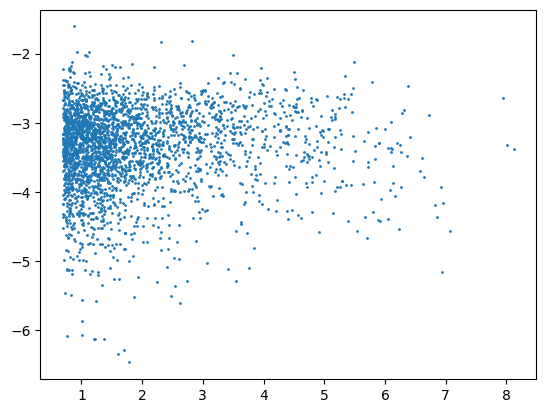

In [26]:
fig,axs = plt.subplots()
axs.scatter(np.log(all_df['Area']), np.log(all_df['mean_complexity']), s=1)

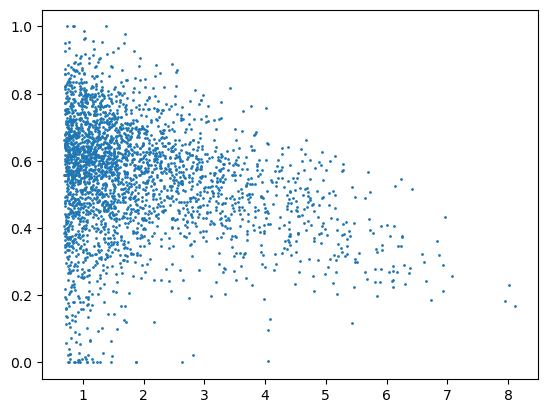

In [22]:
fig,axs = plt.subplots()
axs.scatter(np.log(all_df['Area']), all_df['mean_simplicity'], s=1)

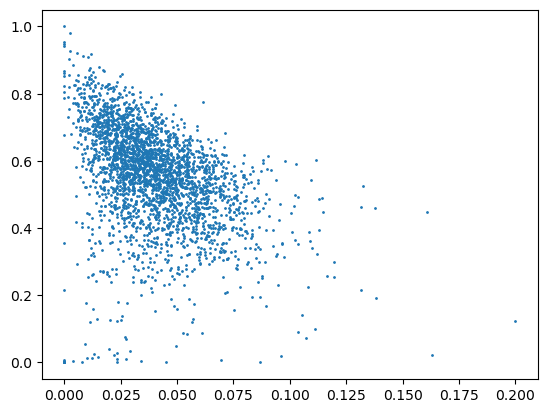

In [25]:
fig,axs = plt.subplots()
axs.scatter(all_df['mean_complexity'], all_df['mean_simplicity'], s=1)